## Immune Landscape–Based Prediction of Breast Cancer Molecular Subtypes

Download instructions:

Raw data from:


## 1. Load & Prepare Data

Here we are loading CIBERSORT data with immune cells fractions and clinical data with breast cancer molecular subtypes. To be able to make one modeling table we need to prepare data accordingly, merge both tables, and filter breast cancer patients for future use.

In [41]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

Load CIBERSORT data

In [42]:
# Define the URL for the immune profiles dataset (CIBERSORT)
tme_data = 'https://raw.githubusercontent.com/ekhlebus/tme-breast-cancer-subtype-prediction/refs/heads/main/data/TCGA.Kallisto.fullIDs.cibersort.relative.tsv'

In [43]:
cibersort = pd.read_csv(tme_data, sep="\t")
cibersort.shape

(11373, 27)

In [44]:
cibersort.head(3)

,SampleID,CancerType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,...,Macrophages.M2,Dendritic.cells.resting,Dendritic.cells.activated,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,P.value,Correlation,RMSE
0,TCGA.OR.A5JG.01A.11R.A29S.07,ACC,0.000000,0.048529,0.016052,0.046099,0.027037,0.290682,0.0,0.000000,...,0.363861,0.002715,0.026125,0.032788,0.00000,0.01029,0.009607,0.112,0.095797,1.047142
1,TCGA.OR.A5LG.01A.11R.A29S.07,ACC,0.007169,0.011125,0.007982,0.139842,0.000000,0.142742,0.0,0.001614,...,0.448243,0.000000,0.007464,0.126237,0.00000,0.00000,0.000000,0.104,0.103345,1.046163
2,TCGA.OR.A5JD.01A.11R.A29S.07,ACC,0.000023,0.014607,0.000000,0.104888,0.000000,0.174895,0.0,0.017928,...,0.329552,0.000000,0.009330,0.000000,0.19073,0.00000,0.000000,0.068,0.143259,1.039812


Extract sample-level TCGA ID and make new column with patient_id

CIBERSORT uses sample-level barcodes, but clinical data is patient-level (first 12 symbols in SampleID).

In [45]:
cibersort["patient_id"] = cibersort.iloc[:, 0].str[:15]
cibersort[["SampleID", "patient_id"]].head()

,SampleID,patient_id
0,TCGA.OR.A5JG.01A.11R.A29S.07,TCGA.OR.A5JG.01
1,TCGA.OR.A5LG.01A.11R.A29S.07,TCGA.OR.A5LG.01
2,TCGA.OR.A5JD.01A.11R.A29S.07,TCGA.OR.A5JD.01
3,TCGA.OR.A5LH.01A.11R.A29S.07,TCGA.OR.A5LH.01
4,TCGA.OR.A5KY.01A.11R.A29S.07,TCGA.OR.A5KY.01


In [46]:
# replace "." with "-" in the patient_id column, since clinical data (below) uses "-" as separator
cibersort["patient_id"] = cibersort["patient_id"].str.replace(".", "-", regex=False)
cibersort[["SampleID", "patient_id"]].head()

,SampleID,patient_id
0,TCGA.OR.A5JG.01A.11R.A29S.07,TCGA-OR-A5JG-01
1,TCGA.OR.A5LG.01A.11R.A29S.07,TCGA-OR-A5LG-01
2,TCGA.OR.A5JD.01A.11R.A29S.07,TCGA-OR-A5JD-01
3,TCGA.OR.A5LH.01A.11R.A29S.07,TCGA-OR-A5LH-01
4,TCGA.OR.A5KY.01A.11R.A29S.07,TCGA-OR-A5KY-01


In [66]:
cibersort_brca = cibersort[cibersort.CancerType == "BRCA"]
cibersort_brca.head(3)

,SampleID,CancerType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,...,Dendritic.cells.resting,Dendritic.cells.activated,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,P.value,Correlation,RMSE,patient_id
512,TCGA.BH.A5J0.01A.11R.A27Q.07,BRCA,0.001898,0.023556,0.010481,0.095533,0.0,0.127552,0.0,0.095345,...,0.019468,0.00000,0.035999,0.000000,0.0,0.0,0.014,0.192839,1.008533,TCGA-BH-A5J0-01
513,TCGA.AR.A5QM.01A.11R.A27Q.07,BRCA,0.093505,0.000000,0.037465,0.096298,0.0,0.014914,0.0,0.054760,...,0.000000,0.00000,0.191294,0.006266,0.0,0.0,0.020,0.177653,1.013417,TCGA-AR-A5QM-01
514,TCGA.E9.A5FL.01A.11R.A27Q.07,BRCA,0.000000,0.076612,0.000323,0.073061,0.0,0.033787,0.0,0.065763,...,0.042529,0.00449,0.030624,0.000000,0.0,0.0,0.000,0.330051,0.952726,TCGA-E9-A5FL-01


Load clinical data

In [47]:
# Define the URL for the clinical dataset (BC Subtypes)
clin_data = 'https://raw.githubusercontent.com/ekhlebus/tme-breast-cancer-subtype-prediction/refs/heads/main/data/BRCA_clinicalMatrix.tsv'
clinical = pd.read_csv(clin_data, sep="\t")
clinical.shape

(1247, 194)

In [48]:
clinical.head(3)

,sampleID,AJCC_Stage_nature2012,Age_at_Initial_Pathologic_Diagnosis_nature2012,CN_Clusters_nature2012,Converted_Stage_nature2012,Days_to_Date_of_Last_Contact_nature2012,Days_to_date_of_Death_nature2012,ER_Status_nature2012,Gender_nature2012,HER2_Final_Status_nature2012,...,_GENOMIC_ID_TCGA_BRCA_mutation_wustl_gene,_GENOMIC_ID_TCGA_BRCA_miRNA_GA,_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2_percentile,_GENOMIC_ID_data/public/TCGA/BRCA/miRNA_GA_gene,_GENOMIC_ID_TCGA_BRCA_gistic2thd,_GENOMIC_ID_data/public/TCGA/BRCA/miRNA_HiSeq_gene,_GENOMIC_ID_TCGA_BRCA_G4502A_07_3,_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2,_GENOMIC_ID_TCGA_BRCA_gistic2,_GENOMIC_ID_TCGA_BRCA_PDMarray
0,TCGA-3C-AAAU-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,6ef883fc-81f3-4089-95e0-86904ffc0d38,NaN,TCGA-3C-AAAU-01A-11D-A41E-01,TCGA-3C-AAAU-01,NaN,6ef883fc-81f3-4089-95e0-86904ffc0d38,TCGA-3C-AAAU-01A-11D-A41E-01,NaN
1,TCGA-3C-AALI-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,dd8d3665-ec9d-45be-b7b9-a85dac3585e2,NaN,TCGA-3C-AALI-01A-11D-A41E-01,TCGA-3C-AALI-01,NaN,dd8d3665-ec9d-45be-b7b9-a85dac3585e2,TCGA-3C-AALI-01A-11D-A41E-01,NaN
2,TCGA-3C-AALJ-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,c924c2a8-ab41-4499-bb30-79705cc17d45,NaN,TCGA-3C-AALJ-01A-31D-A41E-01,TCGA-3C-AALJ-01,NaN,c924c2a8-ab41-4499-bb30-79705cc17d45,TCGA-3C-AALJ-01A-31D-A41E-01,NaN


In [49]:
clinical.columns.tolist()

['sampleID',
 'AJCC_Stage_nature2012',
 'Age_at_Initial_Pathologic_Diagnosis_nature2012',
 'CN_Clusters_nature2012',
 'Converted_Stage_nature2012',
 'Days_to_Date_of_Last_Contact_nature2012',
 'Days_to_date_of_Death_nature2012',
 'ER_Status_nature2012',
 'Gender_nature2012',
 'HER2_Final_Status_nature2012',
 'Integrated_Clusters_no_exp__nature2012',
 'Integrated_Clusters_unsup_exp__nature2012',
 'Integrated_Clusters_with_PAM50__nature2012',
 'Metastasis_Coded_nature2012',
 'Metastasis_nature2012',
 'Node_Coded_nature2012',
 'Node_nature2012',
 'OS_Time_nature2012',
 'OS_event_nature2012',
 'PAM50Call_RNAseq',
 'PAM50_mRNA_nature2012',
 'PR_Status_nature2012',
 'RPPA_Clusters_nature2012',
 'SigClust_Intrinsic_mRNA_nature2012',
 'SigClust_Unsupervised_mRNA_nature2012',
 'Survival_Data_Form_nature2012',
 'Tumor_T1_Coded_nature2012',
 'Tumor_nature2012',
 'Vital_Status_nature2012',
 '_INTEGRATION',
 '_PANCAN_CNA_PANCAN_K8',
 '_PANCAN_Cluster_Cluster_PANCAN',
 '_PANCAN_DNAMethyl_BRCA',
 '_P

In [50]:
# Select ONLY necessary clinical columns
selected_cols = [
    'sampleID',
    'Age_at_Initial_Pathologic_Diagnosis_nature2012',
    'Gender_nature2012',
    'ER_Status_nature2012',
    'PR_Status_nature2012',
    'HER2_Final_Status_nature2012',
    'PAM50Call_RNAseq' # intrinsic subtype (our target variable)
]

clinical_sub = clinical.loc[:, clinical.columns.intersection(selected_cols)]

In [51]:
# Rename columns to cleaner names
clinical_sub = clinical_sub.rename(columns={
    'Age_at_Initial_Pathologic_Diagnosis_nature2012': 'age',
    'Gender_nature2012': 'gender',
    'ER_Status_nature2012': 'ER',
    'PR_Status_nature2012': 'PR',
    'HER2_Final_Status_nature2012': 'HER2',
    'PAM50Call_RNAseq': 'subtype'
})

In [ ]:
clinical_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247 entries, 0 to 1246
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sampleID  1247 non-null   object 
 1   age       952 non-null    float64
 2   ER        782 non-null    object 
 3   gender    952 non-null    object 
 4   HER2      776 non-null    object 
 5   subtype   956 non-null    object 
 6   PR        781 non-null    object 
dtypes: float64(1), object(6)
memory usage: 68.3+ KB


In [ ]:
# Quick data quality check for age column
clinical_sub.age.describe()

count    952.000000
mean      57.720588
std       13.430495
min       26.000000
25%       48.000000
50%       58.000000
75%       66.250000
max       90.000000
Name: age, dtype: float64

Merge immune + clinical tables

In [67]:
cibersort_brca.head(2)

,SampleID,CancerType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,...,Dendritic.cells.resting,Dendritic.cells.activated,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,P.value,Correlation,RMSE,patient_id
512,TCGA.BH.A5J0.01A.11R.A27Q.07,BRCA,0.001898,0.023556,0.010481,0.095533,0.0,0.127552,0.0,0.095345,...,0.019468,0.0,0.035999,0.000000,0.0,0.0,0.014,0.192839,1.008533,TCGA-BH-A5J0-01
513,TCGA.AR.A5QM.01A.11R.A27Q.07,BRCA,0.093505,0.000000,0.037465,0.096298,0.0,0.014914,0.0,0.054760,...,0.000000,0.0,0.191294,0.006266,0.0,0.0,0.020,0.177653,1.013417,TCGA-AR-A5QM-01


In [54]:
clinical_sub.head(2)

,sampleID,age,ER,gender,HER2,subtype,PR
0,TCGA-3C-AAAU-01,NaN,NaN,NaN,NaN,NaN,NaN
1,TCGA-3C-AALI-01,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
cibersort_brca.SampleID.nunique(), cibersort_brca.patient_id.nunique(), clinical_sub.sampleID.nunique()

(1232, 1215, 1247)

In [69]:
# Check duplicates in CIBERSORT
cibersort_brca['patient_id'].duplicated().sum()

np.int64(41)

In [ ]:
# Check duplicated patients in clinical data
cibersort_brca['patient_id'].value_counts().head(10)


patient_id
TCGA-A7-A0DC-01    6
TCGA-A7-A26F-01    5
TCGA-AC-A2QH-01    5
TCGA-AC-A3OD-01    5
TCGA-A7-A26I-01    5
TCGA-A7-A13G-01    5
TCGA-AC-A3QQ-01    4
TCGA-A7-A13D-01    3
TCGA-A7-A26J-01    3
TCGA-A7-A13E-01    3
Name: count, dtype: int64

Here we can see that cibersort contains multiple samples per patient! When merged we will see that one clinical row matches multiple CIBERSORT rows, what leads to duplicated clinical info. This is dangerous for ML, so we need to transform our data to have only one imput for each patient_id. In this case we will aggregate CIBERSORT immune fractions per patient.

In [78]:
non_cell_cols = [
    'SampleID', 'CancerType', 'P.value',
    'Correlation', 'RMSE', 'patient_id'
]

cell_cols = [c for c in cibersort.columns if c not in non_cell_cols]
print(len(cell_cols))
cell_cols


22


['B.cells.naive',
 'B.cells.memory',
 'Plasma.cells',
 'T.cells.CD8',
 'T.cells.CD4.naive',
 'T.cells.CD4.memory.resting',
 'T.cells.CD4.memory.activated',
 'T.cells.follicular.helper',
 'T.cells.regulatory..Tregs.',
 'T.cells.gamma.delta',
 'NK.cells.resting',
 'NK.cells.activated',
 'Monocytes',
 'Macrophages.M0',
 'Macrophages.M1',
 'Macrophages.M2',
 'Dendritic.cells.resting',
 'Dendritic.cells.activated',
 'Mast.cells.resting',
 'Mast.cells.activated',
 'Eosinophils',
 'Neutrophils']

Aggregate CIBERSORT per patient (MEAN)

In [80]:
cibersort_agg = (
    cibersort_brca
    .groupby('patient_id', as_index=False)[cell_cols]
    .mean()
)
cibersort_agg.shape

(1215, 23)

Merge aggregated CIBERSORT with clinical data

In [82]:
len(clinical_sub), len(cibersort_agg)

(1247, 1215)

In [86]:
df = cibersort_agg.merge(
    clinical_sub,
    left_on="patient_id",
    right_on="sampleID",
    how="inner"
)
df = df.drop(columns=['sampleID'])
print(df.shape)
df['patient_id'].duplicated().sum()


(1215, 29)


np.int64(0)

## 2. Initial data preparation (cleaning, filtering)

In [89]:
df.head(3)

,patient_id,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,T.cells.regulatory..Tregs.,...,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,age,ER,gender,HER2,subtype,PR
0,TCGA-3C-AAAU-01,0.048137,0.077700,0.150236,0.070180,0.028799,0.026362,0.0,0.085052,0.000000,...,0.000000,0.000195,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,TCGA-3C-AALI-01,0.005145,0.027327,0.025370,0.234249,0.000000,0.047119,0.0,0.141624,0.091920,...,0.060556,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,TCGA-3C-AALJ-01,0.071389,0.000000,0.011654,0.175914,0.000000,0.112742,0.0,0.114402,0.038368,...,0.013251,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


Sometimes it is difficult to see all columns in a wide dataframe. To take a look at all columns we can transpose dataFrame, so rows become columns and now we can see them better.


In [90]:
df.head().T

,0,1,2,3,4
patient_id,TCGA-3C-AAAU-01,TCGA-3C-AALI-01,TCGA-3C-AALJ-01,TCGA-3C-AALK-01,TCGA-4H-AAAK-01
B.cells.naive,0.048137,0.005145,0.071389,0.010297,0.070785
B.cells.memory,0.0777,0.027327,0.0,0.007828,0.0
Plasma.cells,0.150236,0.02537,0.011654,0.047802,0.050855
T.cells.CD8,0.07018,0.234249,0.175914,0.081922,0.054838
T.cells.CD4.naive,0.028799,0.0,0.0,0.0,0.0
T.cells.CD4.memory.resting,0.026362,0.047119,0.112742,0.183887,0.157011
T.cells.CD4.memory.activated,0.0,0.0,0.0,0.0,0.0
T.cells.follicular.helper,0.085052,0.141624,0.114402,0.074437,0.078674
T.cells.regulatory..Tregs.,0.0,0.09192,0.038368,0.058245,0.002045


In [91]:
df.dtypes

patient_id                       object
B.cells.naive                   float64
B.cells.memory                  float64
Plasma.cells                    float64
T.cells.CD8                     float64
T.cells.CD4.naive               float64
T.cells.CD4.memory.resting      float64
T.cells.CD4.memory.activated    float64
T.cells.follicular.helper       float64
T.cells.regulatory..Tregs.      float64
T.cells.gamma.delta             float64
NK.cells.resting                float64
NK.cells.activated              float64
Monocytes                       float64
Macrophages.M0                  float64
Macrophages.M1                  float64
Macrophages.M2                  float64
Dendritic.cells.resting         float64
Dendritic.cells.activated       float64
Mast.cells.resting              float64
Mast.cells.activated            float64
Eosinophils                     float64
Neutrophils                     float64
age                             float64
ER                               object


Data for subtypes and age are numerical as expected.

Now let's work with subtype variable - our target variable.

In [97]:
# Check subtype values
df.subtype.value_counts(dropna=False)

subtype
LumA      434
NaN       262
LumB      194
Basal     140
Normal    118
Her2       67
Name: count, dtype: int64

In [98]:
# Filter to Basal vs Luminal only, Remove rare / noisy classes
df_sub = df[df["subtype"].isin([
    "Basal",
    "LumA",
    "LumB"
])].copy()

df_sub.subtype.value_counts()

subtype
LumA     434
LumB     194
Basal    140
Name: count, dtype: int64

In [99]:
# Create binary target variable
df_sub["y_basal"] = df_sub["subtype"].map({
    "Basal": 1,
    "LumA": 0,
    "LumB": 0
})

In [100]:
df_sub["y_basal"].value_counts(normalize=True)


y_basal
0    0.817708
1    0.182292
Name: proportion, dtype: float64

We see some imbalance here!

In [9]:
# At first we need to clean the data and make it consistent
df.columns = df.columns.str.lower().str.replace(' ', '_')

string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [10]:
# Now we can see it is more consistent/uniform
df.head().T

,0,1,2,3,4
customerid,7590-vhveg,5575-gnvde,3668-qpybk,7795-cfocw,9237-hqitu
gender,female,male,male,male,female
seniorcitizen,0,0,0,0,0
partner,yes,no,no,no,no
dependents,no,no,no,no,no
tenure,1,34,2,45,2
phoneservice,no,yes,yes,no,yes
multiplelines,no_phone_service,no,no,no_phone_service,no
internetservice,dsl,dsl,dsl,dsl,fiber_optic
onlinesecurity,no,yes,yes,yes,no


In [11]:
df.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges         object
churn                object
dtype: object

We can see next intersting things here: 

* "seniorcitizen" is a number - int64 (not a string yes or no)
* "totalcharges" is an object, but it should be a number

In [12]:
# Let's look at those columns that are not numeric but should be
df.totalcharges
# It looks like a number but it is an object! Maybe there are some non-numeric values?

0         29.85
1        1889.5
2        108.15
3       1840.75
4        151.65
         ...   
7038     1990.5
7039     7362.9
7040     346.45
7041      306.6
7042     6844.5
Name: totalcharges, Length: 7043, dtype: object

In [13]:
# Let's try to convert it to a number
pd.to_numeric(df.totalcharges)
# We get an error! Let's see what values are causing this problem

ValueError: Unable to parse string "_" at position 488

In [14]:
# coerce will ignore non-numeric values and convert them to NaN
tc = pd.to_numeric(df['totalcharges'], errors='coerce')


In [15]:
# Check how many missing values we have
tc.isnull().sum()

np.int64(11)

In [16]:
# Let's find out which values are non-numeric
df[tc.isnull()][['customerid', 'totalcharges']]

,customerid,totalcharges
488,4472-lvygi,_
753,3115-czmzd,_
936,5709-lvoeq,_
1082,4367-nuyao,_
1340,1371-dwpaz,_
3331,7644-omvmy,_
3826,3213-vvolg,_
4380,2520-sgtta,_
5218,2923-arzlg,_
6670,4075-wkniu,_


In [17]:
# Let's replace missing values with 0
df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce')
df['totalcharges'] = df['totalcharges'].fillna(0)

Now let's work with churn variable.

In [18]:
df.churn.head()

0     no
1     no
2    yes
3     no
4    yes
Name: churn, dtype: object

Since we are intersted in numbers we need to converts yes and no to numbers.

In [19]:
# Repleace yes/no with 1/0
df.churn = (df.churn == 'yes').astype(int)

In [20]:
df.head().T

,0,1,2,3,4
customerid,7590-vhveg,5575-gnvde,3668-qpybk,7795-cfocw,9237-hqitu
gender,female,male,male,male,female
seniorcitizen,0,0,0,0,0
partner,yes,no,no,no,no
dependents,no,no,no,no,no
tenure,1,34,2,45,2
phoneservice,no,yes,yes,no,yes
multiplelines,no_phone_service,no,no,no_phone_service,no
internetservice,dsl,dsl,dsl,dsl,fiber_optic
onlinesecurity,no,yes,yes,yes,no


## 3.3 Setting Up The Validation Framework

Let's make next split:
* TRAIN - 60%
* VALIDATION - 20%
* TEST - 20%

Here we will use **Scikit-learn**.

**Scikit-learn** (also known as **sklearn**) is a open-source machine learning library for the Python programming language. It provides a consistent interface for a wide range of algorithms for both supervised and unsupervised learning, along with tools for data preprocessing and model evaluation. This library allows to make a split, so we will use it here.

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
# Split the full dataset into training and testing sets
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
# test_size=0.2 - setting aside 20% of the data for testing
# random_state=1 - setting a seed for reproducibility

In [23]:
len(df_train_full), len(df_test)

(5634, 1409)

In [24]:
# Further split the training set into training and validation sets 
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)

In [25]:
len(df_train), len(df_val)

(4225, 1409)

In [26]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [27]:
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

In [28]:
del df_train['churn']
del df_val['churn']
del df_test['churn']

## 3.4 Exploratory data analysis (EDA)

Here we will use our full train dataset (TRAIN + VALIDATION)!

In [29]:
df_train_full = df_train_full.reset_index(drop=True)

In [30]:
df_train_full.head(3)

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.70,258.35,0
1,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,...,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.90,3160.55,1
2,2176-osjuv,male,0,yes,no,71,yes,yes,dsl,yes,...,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.15,4681.75,0


In [31]:
# Let's look for missing values in the full training set
df_train_full.isnull().sum()
# No missing values! So don't need to do any additional data preparation steps.

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [32]:
# Let's look at the target variable distribution
df_train_full.churn.value_counts()

churn
0    4113
1    1521
Name: count, dtype: int64

In [33]:
# We can look at the proportions/persantage as well
df_train_full.churn.value_counts(normalize=True)

churn
0    0.730032
1    0.269968
Name: proportion, dtype: float64

0.269968 here is a Churn Rate

In [34]:
# The same story here. We can calculate global Churn Rate as mean!
global_mean = df_train_full.churn.mean()
round(global_mean, 3)

np.float64(0.27)

In [35]:
df_train_full.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges        float64
churn                 int64
dtype: object

In [36]:
# We are doing this to see which columns are categorical and which are numerical and also for easier copying later
df_train_full.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

In [37]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [38]:
df_train_full[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

## 3.5 Feature importance: Churn Rate And Risk Ratio

Here instead just looking at global churn rate we can look at churn rate within different groups and check
1. Difference:

    If (Global Churn Rate - Group Churn Rate) > 0 that less likely to churn

    If (Global Churn Rate - Group Churn Rate) <> 0 that more likely to churn
2. Risk Ratio
    
    RISK = Group CR/Global CR (>1 more likely to churn, <1 - less likely)

In [39]:
df_train_full.head(4)

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.70,258.35,0
1,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,...,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.90,3160.55,1
2,2176-osjuv,male,0,yes,no,71,yes,yes,dsl,yes,...,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.15,4681.75,0
3,6161-erdgd,male,0,yes,yes,71,yes,yes,dsl,yes,...,yes,yes,yes,yes,one_year,no,electronic_check,85.45,6300.85,0


In [40]:
# Churn Rate within different gender groups
female_mean = df_train_full[df_train_full.gender == 'female'].churn.mean()
print('gender == female:', round(female_mean, 3))

male_mean = df_train_full[df_train_full.gender == 'male'].churn.mean()
print('gender == male:  ', round(male_mean, 3))

global_mean = df_train_full.churn.mean()
print('global churn rate:  ', round(global_mean, 3))

gender == female: 0.277
gender == male:   0.263
global churn rate:   0.27


Churn Rate among males and females is not so different from the global churn!

In [41]:
female_mean / global_mean

np.float64(1.0253955354648652)

In [42]:
male_mean / global_mean

np.float64(0.9749802969838747)

Now we can do the same for partner.

In [43]:
df_train_full.partner.value_counts()

partner
no     2932
yes    2702
Name: count, dtype: int64

In [44]:
partner_yes = df_train_full[df_train_full.partner == 'yes'].churn.mean()
print('partner == yes:', round(partner_yes, 3))

partner_no = df_train_full[df_train_full.partner == 'no'].churn.mean()
print('partner == no :', round(partner_no, 3))

partner == yes: 0.205
partner == no : 0.33


For people without partner Churt rate is around 5% more than global churn rate. It gives us the some idea that the partner variable is more important for predicting churn than gender variable.

In [45]:
global_mean - partner_yes

np.float64(0.06493474245795922)

In [46]:
partner_yes / global_mean

np.float64(0.7594724924338315)

In [47]:
partner_no / global_mean

np.float64(1.2216593879412643)

Let's calculate difference and risk for different groups

In [48]:
df_group = df_train_full.groupby(by='gender').churn.agg(['mean', 'count'])
df_group['diff'] = df_group['mean'] - global_mean # Add difference column
df_group['risk'] = df_group['mean'] / global_mean
df_group

,mean,count,diff,risk
gender,,,,
female,0.276824,2796,0.006856,1.025396
male,0.263214,2838,-0.006755,0.974980


Now we want to do this for each categorical variables. We can do it in for loop. Since just in for loop we can't display final data frame, we will use **IPython.display** library.

In [49]:
from IPython.display import display

In [50]:
for col in categorical:
    df_group = df_train_full.groupby(by=col).churn.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_mean
    df_group['risk'] = df_group['mean'] / global_mean
    display(df_group)

,mean,count,diff,risk
gender,,,,
female,0.276824,2796,0.006856,1.025396
male,0.263214,2838,-0.006755,0.974980


,mean,count,diff,risk
seniorcitizen,,,,
0,0.242270,4722,-0.027698,0.897403
1,0.413377,912,0.143409,1.531208


,mean,count,diff,risk
partner,,,,
no,0.329809,2932,0.059841,1.221659
yes,0.205033,2702,-0.064935,0.759472


,mean,count,diff,risk
dependents,,,,
no,0.313760,3968,0.043792,1.162212
yes,0.165666,1666,-0.104302,0.613651


,mean,count,diff,risk
phoneservice,,,,
no,0.241316,547,-0.028652,0.893870
yes,0.273049,5087,0.003081,1.011412


,mean,count,diff,risk
multiplelines,,,,
no,0.257407,2700,-0.012561,0.953474
no_phone_service,0.241316,547,-0.028652,0.893870
yes,0.290742,2387,0.020773,1.076948


,mean,count,diff,risk
internetservice,,,,
dsl,0.192347,1934,-0.077621,0.712482
fiber_optic,0.425171,2479,0.155203,1.574895
no,0.077805,1221,-0.192163,0.288201


,mean,count,diff,risk
onlinesecurity,,,,
no,0.420921,2801,0.150953,1.559152
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.153226,1612,-0.116742,0.567570


,mean,count,diff,risk
onlinebackup,,,,
no,0.404323,2498,0.134355,1.497672
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.217232,1915,-0.052736,0.804660


,mean,count,diff,risk
deviceprotection,,,,
no,0.395875,2473,0.125907,1.466379
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.230412,1940,-0.039556,0.853480


,mean,count,diff,risk
techsupport,,,,
no,0.418914,2781,0.148946,1.551717
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.159926,1632,-0.110042,0.592390


,mean,count,diff,risk
streamingtv,,,,
no,0.342832,2246,0.072864,1.269897
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.302723,2167,0.032755,1.121328


,mean,count,diff,risk
streamingmovies,,,,
no,0.338906,2213,0.068938,1.255358
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.307273,2200,0.037305,1.138182


,mean,count,diff,risk
contract,,,,
month-to-month,0.431701,3104,0.161733,1.599082
one_year,0.120573,1186,-0.149395,0.446621
two_year,0.028274,1344,-0.241694,0.104730


,mean,count,diff,risk
paperlessbilling,,,,
no,0.172071,2313,-0.097897,0.637375
yes,0.338151,3321,0.068183,1.252560


,mean,count,diff,risk
paymentmethod,,,,
bank_transfer_(automatic),0.168171,1219,-0.101797,0.622928
credit_card_(automatic),0.164339,1217,-0.105630,0.608733
electronic_check,0.455890,1893,0.185922,1.688682
mailed_check,0.193870,1305,-0.076098,0.718121


Now let's make bar plot to see results on the plot

In [51]:
# Step 1 — Collect all category results into one DataFrame
result_list = []

for col in categorical:
    # aggregate churn by the column
    df_group = (
        df_train_full
        .groupby(col)['churn']
        .agg(mean='mean', count='count')
        .reset_index()
        .rename(columns={col: 'category'})   # <-- standardize column name
    )

    df_group['feature'] = col
    df_group['diff'] = df_group['mean'] - global_mean
    df_group['risk'] = df_group['mean'] / global_mean

    # keep a consistent column order
    result_list.append(df_group[['feature', 'category', 'mean', 'count', 'diff', 'risk']])

df_all = pd.concat(result_list, ignore_index=True)

In [52]:
df_all.head(4)

,feature,category,mean,count,diff,risk
0,gender,female,0.276824,2796,0.006856,1.025396
1,gender,male,0.263214,2838,-0.006755,0.974980
2,seniorcitizen,0,0.242270,4722,-0.027698,0.897403
3,seniorcitizen,1,0.413377,912,0.143409,1.531208


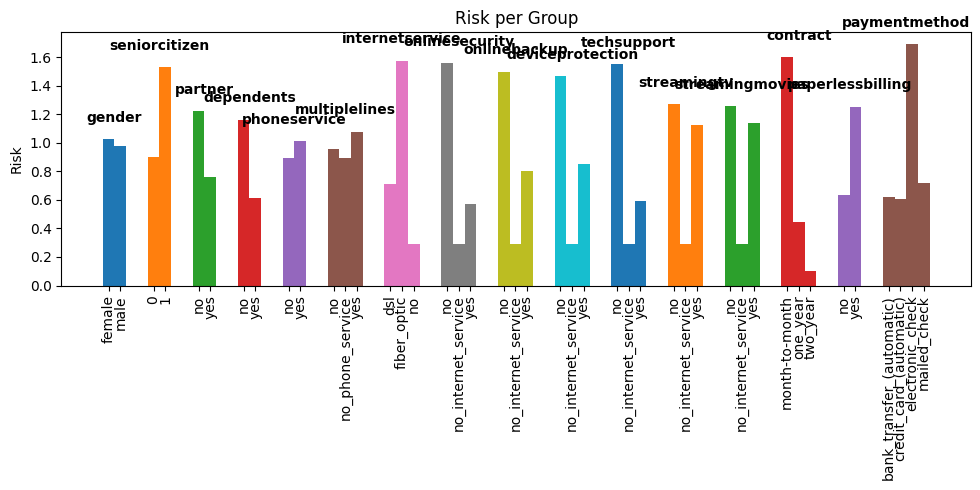

In [53]:
# unique groups
features = df_all['feature'].unique()
categories = df_all['category'].astype(str).unique()

plt.figure(figsize=(10, 5))

# parameters controlling spacing
group_width = 0.8          # width of each feature-group segment
bar_width = 0.35           # width of individual bars
group_spacing = 1       # extra gap between features

x_positions = []
x_labels = []

current_x = 0

for feature in features:
    sub = df_all[df_all['feature'] == feature].copy()
    sub = sub.sort_values('category')     # nicer consistent order
    
    xs = current_x + np.arange(len(sub)) * bar_width
    plt.bar(xs, sub['risk'], width=bar_width, label=feature)
    
    # save x ticks and labels
    for x, cat in zip(xs, sub['category']):
        x_positions.append(x)
        x_labels.append(str(cat))
    
    # ---- Add feature label above group ----
    group_center = xs.mean()
    plt.text(group_center, 
             sub['risk'].max() + 0.1,     # vertical position
             feature, 
             ha='center', va='bottom', fontsize=10, fontweight='bold')
    # add spacing before next feature
    current_x = xs[-1] + group_spacing

plt.ylabel("Risk")
plt.title("Risk per Group")
plt.xticks(x_positions, x_labels, rotation=90, ha='center')
plt.tight_layout()
plt.show()

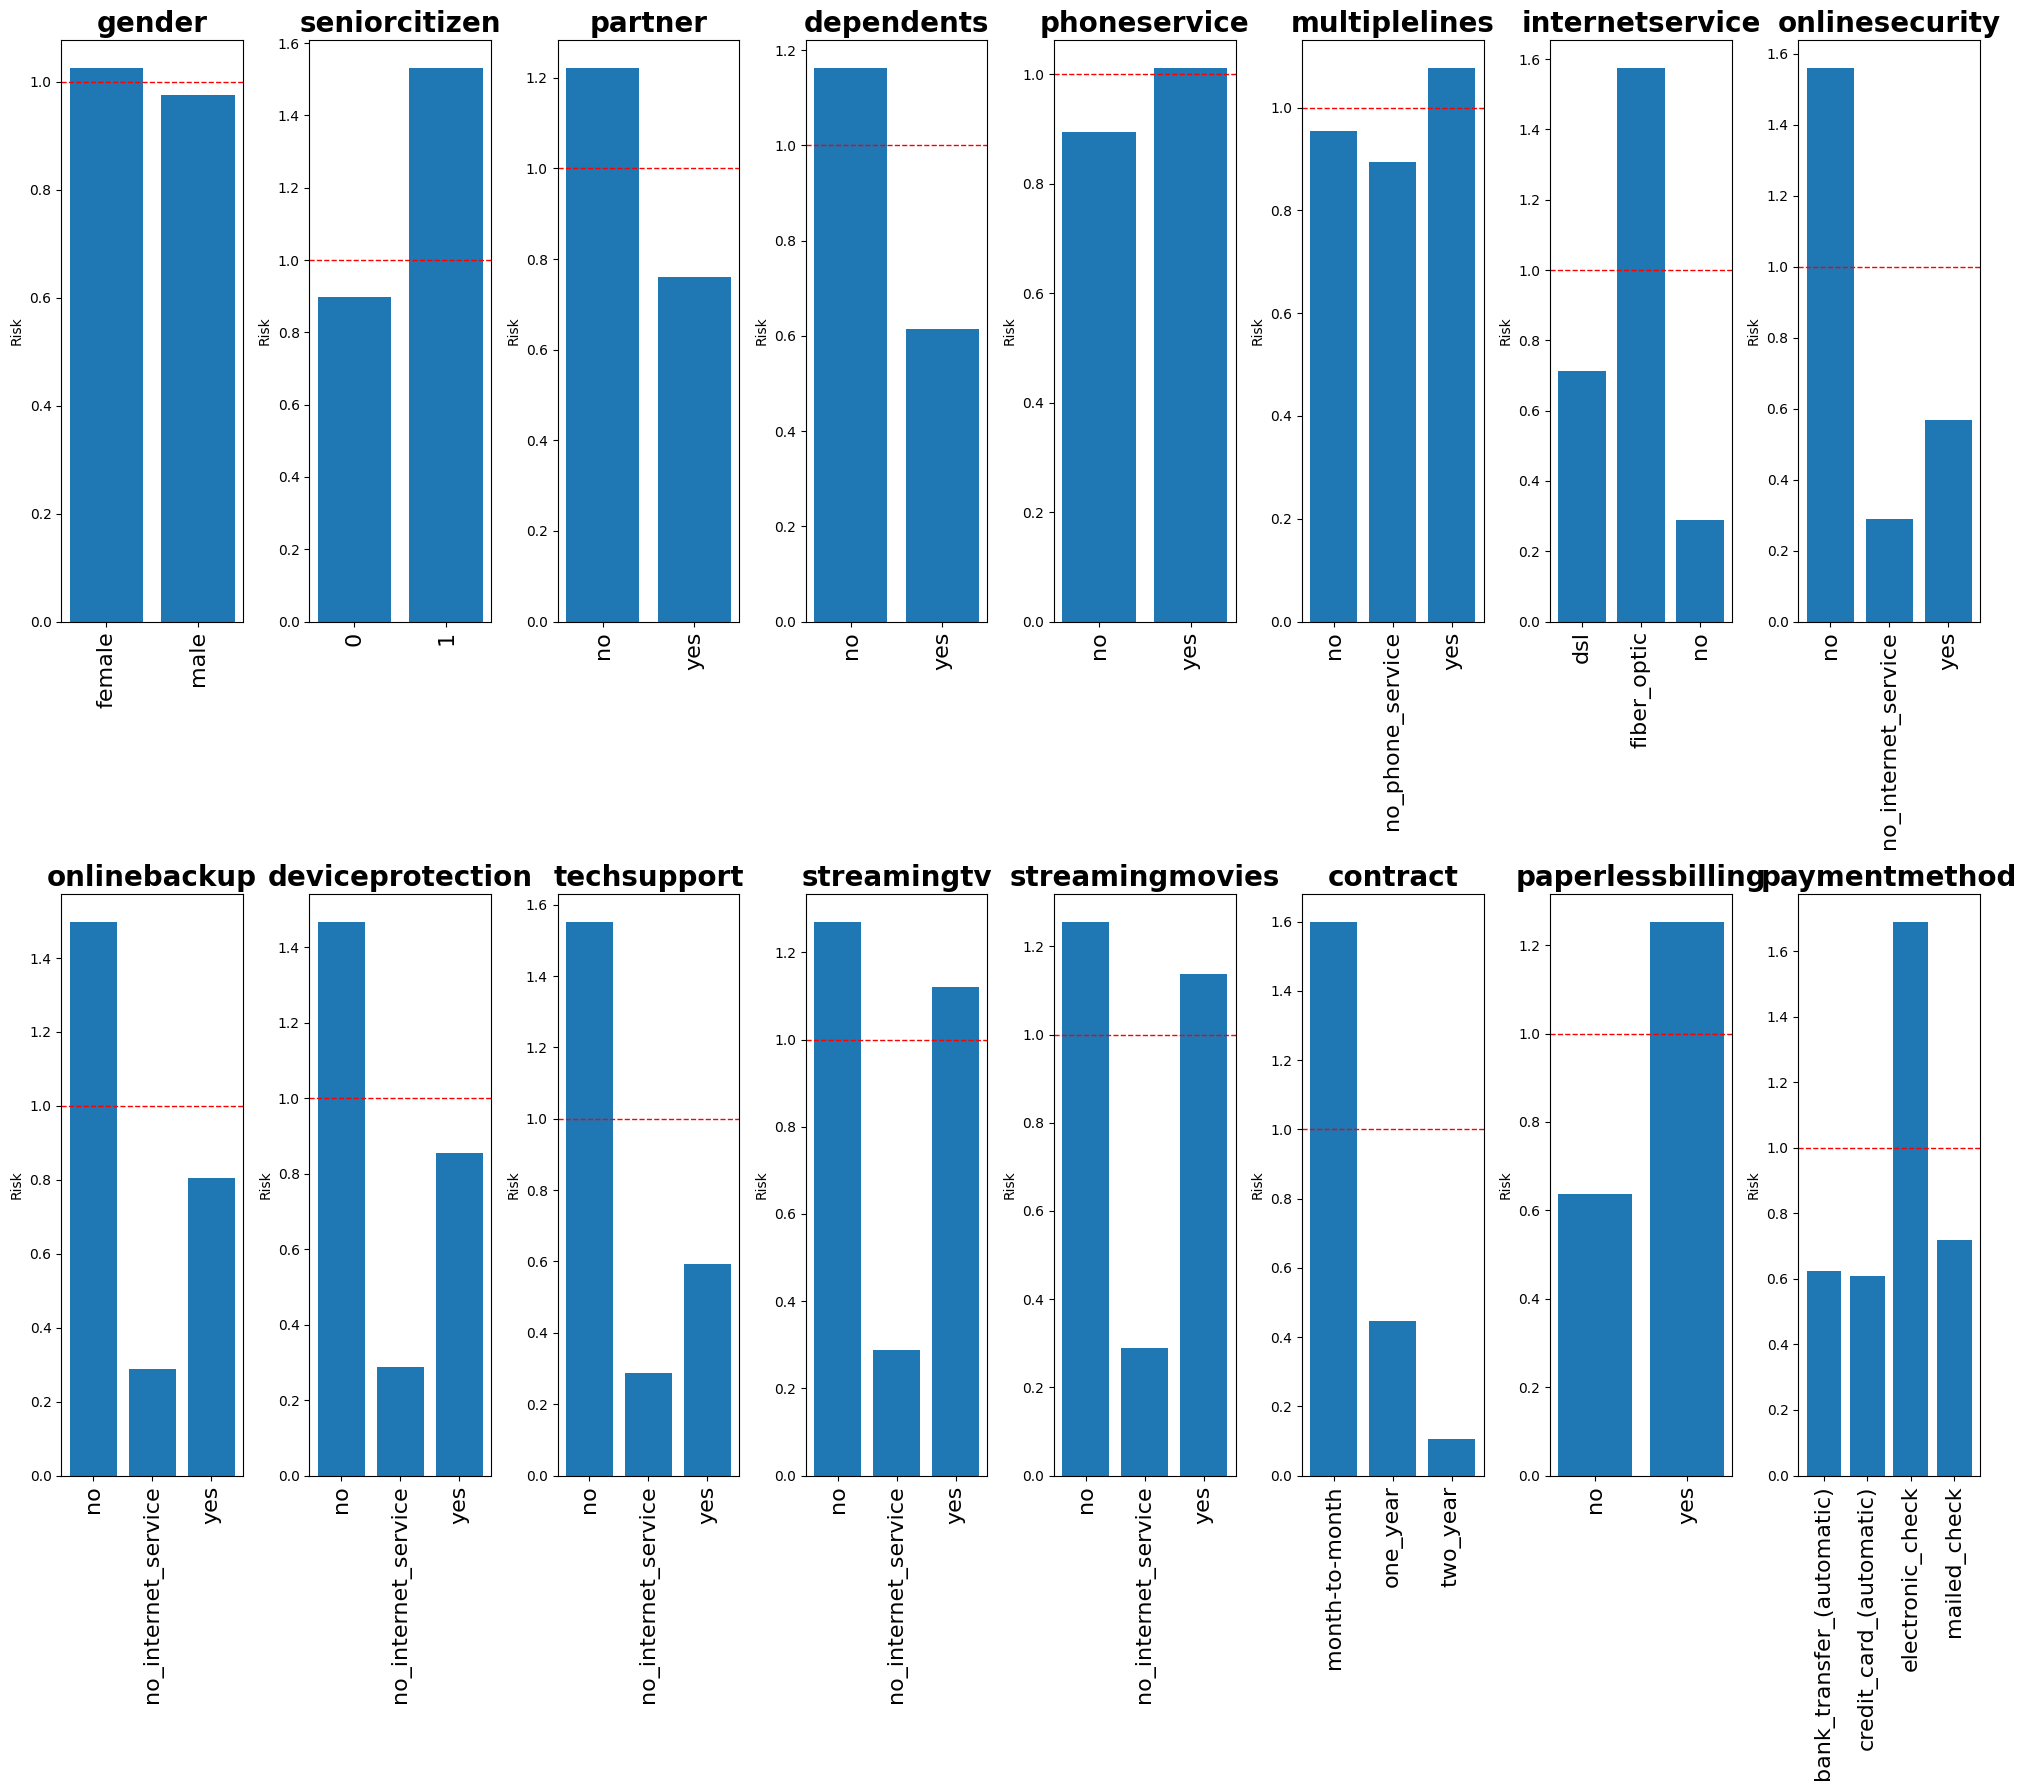

In [54]:
# Let's make subplots for each feature to see the results more clearly
# Choose grid size (change if you have more/fewer features)
rows = 2
cols = 8

features = df_all['feature'].unique()
num_features = len(features)

fig, axes = plt.subplots(rows, cols, figsize=(20, 18))
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]
    sub = df_all[df_all['feature'] == feature].copy()
    sub = sub.sort_values('category')

    # bar plot
    ax.bar(sub['category'].astype(str), sub['risk'])
    ax.set_title(feature, fontsize=20, fontweight="bold")
    ax.tick_params(axis='x', rotation=90, labelsize=16)
    ax.set_ylabel("Risk")

    # --- add horizontal dashed line at risk = 1 ---
    ax.axhline(y=1, color='red', linestyle='--', linewidth=1)

# Turn off unused subplots
for j in range(i + 1, rows * cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## 3.6 Feature Importance: Mutual Information

Mutual information - concept from information theory, it tells us how much we can learn about one variable if we know the value of another.

Let's find some measure about which variable is the most important.

In [55]:
from sklearn.metrics import mutual_info_score

In [56]:
mutual_info_score(df_train_full.churn, df_train_full.contract) # same regardless of the order
# It shows how much information about churn we get by knowing the contract type

0.0983203874041556

In [57]:
mutual_info_score(df_train_full.churn, df_train_full.gender)
# in contrast, knowing gender provides almost no information about churn

0.0001174846211139946

In [58]:
mutual_info_score(df_train_full.churn, df_train_full.partner)


0.009967689095399745

Interpretation of these numbers is tricky but we can learn what is the relative importance.

'contract' is more important than 'partner', and 'partner' is more important than 'gender'

So we can apply this metric to all variables and get understanding which of then has the best/worst mutual information. For that we will use function **apply()**, but apply takes as input a function with one argument, so we need to wrap mutual_info_score function into a function with one argument.

In [59]:
# function to calculate mutual information with churn
def calculate_mi(series):
    return mutual_info_score(series, df_train_full.churn)

df_mi = df_train_full[categorical].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')


display(df_mi.head(3)) # the most important variables
display(df_mi.tail(3))

,MI
contract,0.098320
onlinesecurity,0.063085
techsupport,0.061032


,MI
multiplelines,0.000857
phoneservice,0.000229
gender,0.000117


## 3.7 - Feature Importance: Correlation

This is a way to measure Feature Importance to **numerical** vatiables. And here we are talking about Pearson's correlation - this is way to measure dependency between two variables.

Pearson correlation coefficient (r) - https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

-1 <= r <= 1

In [60]:
df_train_full.tenure.max()

np.int64(72)

For example, let's consider tenure.
In our case:
* x in [0, 72] - tenure (number of month with provider)
* y = 0 or y = 1 - churn

So, since y is binary, we will use point-biserial correlation, which is numerically equivalent to Pearson.

In [61]:
# Let's look at our numerical variables now
df_train_full[numerical].head(3)

,tenure,monthlycharges,totalcharges
0,12,19.70,258.35
1,42,73.90,3160.55
2,71,65.15,4681.75


In [62]:
df_train_full[numerical].corrwith(df_train_full.churn).to_frame('correlation')

,correlation
tenure,-0.351885
monthlycharges,0.196805
totalcharges,-0.196353


In [63]:
# Let's look at the churn rate for customers with tenure less than or equal to 2 months
df_train_full[df_train_full.tenure <= 2].churn.mean()

np.float64(0.5953420669577875)

In [64]:
df_train_full[df_train_full.tenure > 2].churn.mean()

np.float64(0.22478269658378816)

In [65]:
# Let's check what is churn rate for customers with tenure more than 2 months and less than one year
df_train_full[(df_train_full.tenure > 2) & (df_train_full.tenure <= 12)].churn.mean()

np.float64(0.3994413407821229)

In [66]:
df_train_full[df_train_full.tenure > 12].churn.mean()

np.float64(0.17634908339788277)

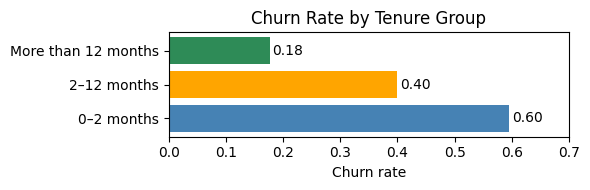

In [67]:
# compute values for churn rate by tenure groups
v1 = df_train_full[df_train_full.tenure <= 2].churn.mean()
v2 = df_train_full[(df_train_full.tenure > 2) & (df_train_full.tenure <= 12)].churn.mean()
v3 = df_train_full[df_train_full.tenure > 12].churn.mean()

values = [v1, v2, v3]
labels = ["0–2 months", "2–12 months", "More than 12 months"]
colors = ["steelblue", "orange", "seagreen"]   # three different colors

# horizontal bar plot
plt.figure(figsize=(6, 2))
plt.barh(labels, values, color=colors)
plt.xlabel("Churn rate")
plt.title("Churn Rate by Tenure Group")

# optional: show values on bars
for i, v in enumerate(values):
    plt.text(v + 0.005, i, f"{v:.2f}", va='center')

# set max axis tick / limit
plt.xlim(0, 0.7)

plt.tight_layout()
plt.show()

Let's look at monthly charges

<Axes: >

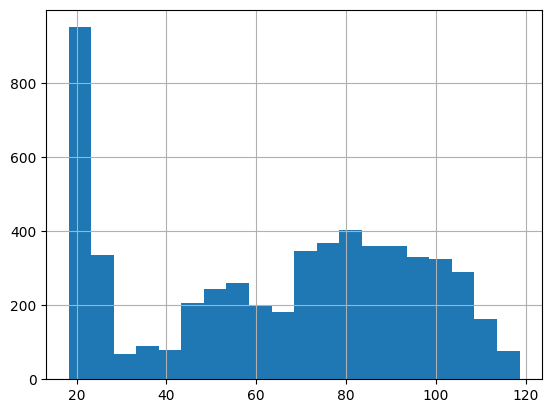

In [68]:
df_train_full.monthlycharges.hist(bins=20)

<>:7: SyntaxWarning: invalid escape sequence '\$'
<>:7: SyntaxWarning: invalid escape sequence '\$'
<>:7: SyntaxWarning: invalid escape sequence '\$'
<>:7: SyntaxWarning: invalid escape sequence '\$'
<>:7: SyntaxWarning: invalid escape sequence '\$'
<>:7: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipykernel_1687/3942996180.py:7: SyntaxWarning: invalid escape sequence '\$'
  labels = ["Less than \$20", "\$20-\$50 per month", "More than \$50"]
/tmp/ipykernel_1687/3942996180.py:7: SyntaxWarning: invalid escape sequence '\$'
  labels = ["Less than \$20", "\$20-\$50 per month", "More than \$50"]
/tmp/ipykernel_1687/3942996180.py:7: SyntaxWarning: invalid escape sequence '\$'
  labels = ["Less than \$20", "\$20-\$50 per month", "More than \$50"]


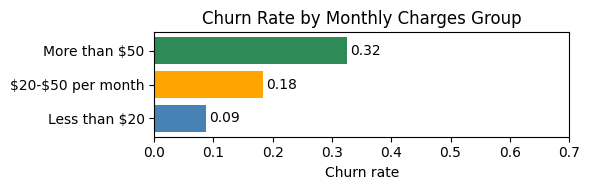

In [69]:
# compute values for churn rate by monthly charges groups
v1 = df_train_full[df_train_full.monthlycharges <= 20].churn.mean()
v2 = df_train_full[(df_train_full.monthlycharges > 20) & (df_train_full.monthlycharges <= 50)].churn.mean()
v3 = df_train_full[df_train_full.monthlycharges > 50].churn.mean()

values = [v1, v2, v3]
labels = ["Less than \$20", "\$20-\$50 per month", "More than \$50"]
colors = ["steelblue", "orange", "seagreen"]   # three different colors

# horizontal bar plot
plt.figure(figsize=(6, 2))
plt.barh(labels, values, color=colors)
plt.xlabel("Churn rate")
plt.title("Churn Rate by Monthly Charges Group")

# optional: show values on bars
for i, v in enumerate(values):
    plt.text(v + 0.005, i, f"{v:.2f}", va='center')

# set max axis tick / limit
plt.xlim(0, 0.7)

plt.tight_layout()
plt.show()

In [70]:
df_train_full.groupby(by='churn')[numerical].mean()

,tenure,monthlycharges,totalcharges
churn,,,
0,37.531972,61.176477,2548.021627
1,18.070348,74.521203,1545.689415


## 3.8 One-hot encoding

Let's see how we can encode categorical variables before we can put them in the model.

Here we again will use **one-hot encoding** as we did when we made regression model for car price prediction.

One-hot encoding converts categorical values into separate binary columns where each column indicates the presence of a specific category. Here to do that we will use Scikit-learn library.

In [71]:
from sklearn.feature_extraction import DictVectorizer

In [72]:
df_train[['gender', 'contract']].iloc[:6]

,gender,contract
0,female,one_year
1,female,month-to-month
2,male,two_year
3,female,month-to-month
4,female,month-to-month
5,female,one_year


In [73]:
# Convert to list of dictionaries row-wise (each record turned into a dictionary)
dicts = df_train[['gender', 'contract']].iloc[:6].to_dict(orient='records')
dicts

[{'gender': 'female', 'contract': 'one_year'},
 {'gender': 'female', 'contract': 'month-to-month'},
 {'gender': 'male', 'contract': 'two_year'},
 {'gender': 'female', 'contract': 'month-to-month'},
 {'gender': 'female', 'contract': 'month-to-month'},
 {'gender': 'female', 'contract': 'one_year'}]

In [74]:
# Create new instance of DictVectorizer class
dv = DictVectorizer(sparse=False)

In [75]:
# Here we train the DictVectorizer on our list of dictionaries,
# showing how our data looks like
dv.fit(dicts)

,dtype,<class 'numpy.float64'>
,separator,'='
,sparse,False
,sort,True


In [76]:
# Here we will use dictionary and convert it to a vector
dv.transform(dicts)
# It produce a sparse matrix since we have many zeroes, but we will not use sparse matrices here

array([[0., 1., 0., 1., 0.],
       [1., 0., 0., 1., 0.],
       [0., 0., 1., 0., 1.],
       [1., 0., 0., 1., 0.],
       [1., 0., 0., 1., 0.],
       [0., 1., 0., 1., 0.]])

In [77]:
# Get feature names created by one-hot encoding
dv.get_feature_names_out()
# DictVectorizer in newer versions of scikit-learn no longer has get_feature_names() — you must use get_feature_names_out() instead.

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'gender=female', 'gender=male'], dtype=object)

DictVectorizer smart enough so if we provide also numerical feature it will leave it intact!

So now instead of giving to DictVectorizer only two or three features we provide whole dataset.

In [78]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')

In [79]:
train_dict[0]

{'gender': 'female',
 'seniorcitizen': 0,
 'partner': 'yes',
 'dependents': 'yes',
 'phoneservice': 'yes',
 'multiplelines': 'yes',
 'internetservice': 'fiber_optic',
 'onlinesecurity': 'no',
 'onlinebackup': 'yes',
 'deviceprotection': 'yes',
 'techsupport': 'no',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'one_year',
 'paperlessbilling': 'yes',
 'paymentmethod': 'credit_card_(automatic)',
 'tenure': 58,
 'monthlycharges': 105.2,
 'totalcharges': 6225.4}

In [80]:
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

,dtype,<class 'numpy.float64'>
,separator,'='
,sparse,False
,sort,True


In [81]:
dv.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'dependents=no', 'dependents=yes',
       'deviceprotection=no', 'deviceprotection=no_internet_service',
       'deviceprotection=yes', 'gender=female', 'gender=male',
       'internetservice=dsl', 'internetservice=fiber_optic',
       'internetservice=no', 'monthlycharges', 'multiplelines=no',
       'multiplelines=no_phone_service', 'multiplelines=yes',
       'onlinebackup=no', 'onlinebackup=no_internet_service',
       'onlinebackup=yes', 'onlinesecurity=no',
       'onlinesecurity=no_internet_service', 'onlinesecurity=yes',
       'paperlessbilling=no', 'paperlessbilling=yes', 'partner=no',
       'partner=yes', 'paymentmethod=bank_transfer_(automatic)',
       'paymentmethod=credit_card_(automatic)',
       'paymentmethod=electronic_check', 'paymentmethod=mailed_check',
       'phoneservice=no', 'phoneservice=yes', 'seniorcitizen',
       'streamingmovies=no', 'streamingmovies=no_internet_service',

In [82]:
dv.transform(train_dict[:5])[0]

array([0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
       0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0520e+02, 0.0000e+00,
       0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
       1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
       0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
       1.0000e+00, 0.0000e+00, 0.0000e+00, 5.8000e+01, 6.2254e+03])

In [83]:
X_train = dv.transform(train_dict)

In [84]:
X_train.shape

(4225, 45)

In [85]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')

In [86]:
# We don't fit on validation dataset!
X_val = dv.transform(val_dict)

## 3.9 Logistic regression

Here we will discuss the difference between Linear and Logistic regression and talk about sigmoid function (z is the input to sigmoid) which allows convert score z into probability.

In [87]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [88]:
# Get numbers between -5 and 5
z = np.linspace(-5, 5, 51)
z

array([-5. , -4.8, -4.6, -4.4, -4.2, -4. , -3.8, -3.6, -3.4, -3.2, -3. ,
       -2.8, -2.6, -2.4, -2.2, -2. , -1.8, -1.6, -1.4, -1.2, -1. , -0.8,
       -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,
        1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,
        3.8,  4. ,  4.2,  4.4,  4.6,  4.8,  5. ])

In [89]:
sigmoid(z)
# we are getting numbers between 0 and 1

array([0.00669285, 0.00816257, 0.0099518 , 0.01212843, 0.01477403,
       0.01798621, 0.02188127, 0.02659699, 0.03229546, 0.03916572,
       0.04742587, 0.05732418, 0.06913842, 0.0831727 , 0.09975049,
       0.11920292, 0.14185106, 0.16798161, 0.19781611, 0.23147522,
       0.26894142, 0.31002552, 0.35434369, 0.40131234, 0.450166  ,
       0.5       , 0.549834  , 0.59868766, 0.64565631, 0.68997448,
       0.73105858, 0.76852478, 0.80218389, 0.83201839, 0.85814894,
       0.88079708, 0.90024951, 0.9168273 , 0.93086158, 0.94267582,
       0.95257413, 0.96083428, 0.96770454, 0.97340301, 0.97811873,
       0.98201379, 0.98522597, 0.98787157, 0.9900482 , 0.99183743,
       0.99330715])

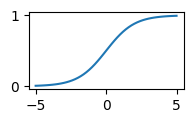

In [90]:
plt.figure(figsize=(2, 1))   # width=4 inches, height=3 inches
plt.plot(z, sigmoid(z))

In [91]:
def linear_regression(xi):
    result = w0 
    
    for j in range(len(w)):
        result = result + xi[j] * w[j]
    return result

In [92]:
def logistic_regression(xi):
    score = w0 
    
    for j in range(len(w)):
        score = score + xi[j] * w[j]
    
    result = sigmoid(score)
    return result

Both linear and logistic regression called linear models because in both models we have "result + xi[j] * w[j]", so in both cases they use dot products (linear operators in linear algebra). These models are relatively fast and good qualities (fast to use, fast to train, good properties).

## 3.10 - Training Logistic Regression with Scikit-Learn

* Train a model with Scikit-Learn
* Apply it to the validation dataset
* Calculate the accuracy

In [93]:
from sklearn.linear_model import LogisticRegression

In [94]:
# Create the model
model = LogisticRegression(solver='liblinear', random_state=1)

# Train the model with dataset, created earlier in lesson 3.8
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,1
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [95]:
model.intercept_[0]

np.float64(-0.1309377295167705)

In [96]:
# Let's look inside the model, this is how we can access the weights
model.coef_[0].round(3)

array([ 0.573, -0.166, -0.538, -0.016, -0.114,  0.076, -0.114, -0.093,
       -0.026, -0.105, -0.353,  0.336, -0.114,  0.001, -0.171,  0.112,
       -0.072,  0.12 , -0.114, -0.137,  0.263, -0.114, -0.28 , -0.207,
        0.076, -0.107, -0.024, -0.056, -0.116,  0.208, -0.167,  0.112,
       -0.243,  0.251, -0.099, -0.114,  0.081, -0.094, -0.114,  0.077,
        0.203, -0.114, -0.22 , -0.065,  0.   ])

In [97]:
# let's use the model and get HARD predictions (1 - churn, 0 - no churn)
model.predict(X_train)

array([0, 1, 0, ..., 0, 0, 0], shape=(4225,))

In [98]:
# Also we can get SOFT predictions with probabilities
model.predict_proba(X_train)
# First column in this 2D array is the probability of class 0 (no churn)
# Second column is the probability of class 1 (churn)

array([[0.78446595, 0.21553405],
       [0.28317038, 0.71682962],
       [0.99853013, 0.00146987],
       ...,
       [0.89584299, 0.10415701],
       [0.89782162, 0.10217838],
       [0.89476342, 0.10523658]], shape=(4225, 2))

In [99]:
# Using those predicted probabilities, we can set up a custom threshold
y_pred = (model.predict_proba(X_train)[:, 1] >= 0.3).astype(int)
y_pred

array([0, 1, 0, ..., 0, 0, 0], shape=(4225,))

In [100]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [101]:
model.predict_proba(X_val)

array([[0.76799773, 0.23200227],
       [0.75226245, 0.24773755],
       [0.72286754, 0.27713246],
       ...,
       [0.99773199, 0.00226801],
       [0.8774217 , 0.1225783 ],
       [0.99855878, 0.00144122]], shape=(1409, 2))

In [102]:
y_pred = model.predict_proba(X_val)[:, 1]

In [103]:
y_pred

array([0.23200227, 0.24773755, 0.27713246, ..., 0.00226801, 0.1225783 ,
       0.00144122], shape=(1409,))

In [104]:
churn_decision = y_pred >= 0.5
churn_decision

array([False, False, False, ..., False, False, False], shape=(1409,))

In [105]:
# Get customer IDs for people we predict will churn
# Now we can send them an email with a special offer
df_val[churn_decision].customerid

10      6551-gnydg
16      0689-nkylf
18      3398-fshon
19      4704-eryfc
26      8258-gstjk
           ...    
1387    1965-ddbwu
1388    2694-ciumo
1389    9389-acwbi
1393    8837-vvwlq
1405    4273-mbhya
Name: customerid, Length: 337, dtype: object

Now we have our predictions. Let's check how accurate they are. For linear regression we used RMSE to measure performance of our model, here we can use something similar, it called **accuracy** - it tells us how many correct predictions we made.

In [106]:
y_val

array([0, 1, 0, ..., 0, 0, 0], shape=(1409,))

In [107]:
churn_decision.astype(int)

array([0, 0, 0, ..., 0, 0, 0], shape=(1409,))

Now we can see how many y_val and churn_decision match.

In [108]:
# Calculate accuracy of boolean array
(y_val == churn_decision).mean()

np.float64(0.7991483321504613)

## 3.11 Model interpretation

* Look at the coefficients
* Train a smaller model with fewer features

In [109]:
# Dictionary vectorizer with feature names
dv.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'dependents=no', 'dependents=yes',
       'deviceprotection=no', 'deviceprotection=no_internet_service',
       'deviceprotection=yes', 'gender=female', 'gender=male',
       'internetservice=dsl', 'internetservice=fiber_optic',
       'internetservice=no', 'monthlycharges', 'multiplelines=no',
       'multiplelines=no_phone_service', 'multiplelines=yes',
       'onlinebackup=no', 'onlinebackup=no_internet_service',
       'onlinebackup=yes', 'onlinesecurity=no',
       'onlinesecurity=no_internet_service', 'onlinesecurity=yes',
       'paperlessbilling=no', 'paperlessbilling=yes', 'partner=no',
       'partner=yes', 'paymentmethod=bank_transfer_(automatic)',
       'paymentmethod=credit_card_(automatic)',
       'paymentmethod=electronic_check', 'paymentmethod=mailed_check',
       'phoneservice=no', 'phoneservice=yes', 'seniorcitizen',
       'streamingmovies=no', 'streamingmovies=no_internet_service',

In [110]:
model.coef_[0].round(3)

array([ 0.573, -0.166, -0.538, -0.016, -0.114,  0.076, -0.114, -0.093,
       -0.026, -0.105, -0.353,  0.336, -0.114,  0.001, -0.171,  0.112,
       -0.072,  0.12 , -0.114, -0.137,  0.263, -0.114, -0.28 , -0.207,
        0.076, -0.107, -0.024, -0.056, -0.116,  0.208, -0.167,  0.112,
       -0.243,  0.251, -0.099, -0.114,  0.081, -0.094, -0.114,  0.077,
        0.203, -0.114, -0.22 , -0.065,  0.   ])

Now if we take features from dv.get_feature_names_out() and join them with coefficients from model.coef_[0].round(3), we will see what is the weight of each feature.

In [111]:
model.intercept_[0].tolist()

-0.1309377295167705

Later we will use **zip**. Let's see what zip is doing.

In [112]:
# We have two lists
a = [1, 2, 3, 4]
b = 'abcd'

In [113]:
# zip join elements from two lists
list(zip(a, b))

[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]

In [114]:
# Here all elements from list a become keys, and from list b become values
dict(zip(a, b))

{1: 'a', 2: 'b', 3: 'c', 4: 'd'}

In [115]:
dict(zip(dv.get_feature_names_out(), model.coef_[0].round(3).tolist()))

{'contract=month-to-month': 0.573,
 'contract=one_year': -0.166,
 'contract=two_year': -0.538,
 'dependents=no': -0.016,
 'dependents=yes': -0.114,
 'deviceprotection=no': 0.076,
 'deviceprotection=no_internet_service': -0.114,
 'deviceprotection=yes': -0.093,
 'gender=female': -0.026,
 'gender=male': -0.105,
 'internetservice=dsl': -0.353,
 'internetservice=fiber_optic': 0.336,
 'internetservice=no': -0.114,
 'monthlycharges': 0.001,
 'multiplelines=no': -0.171,
 'multiplelines=no_phone_service': 0.112,
 'multiplelines=yes': -0.072,
 'onlinebackup=no': 0.12,
 'onlinebackup=no_internet_service': -0.114,
 'onlinebackup=yes': -0.137,
 'onlinesecurity=no': 0.263,
 'onlinesecurity=no_internet_service': -0.114,
 'onlinesecurity=yes': -0.28,
 'paperlessbilling=no': -0.207,
 'paperlessbilling=yes': 0.076,
 'partner=no': -0.107,
 'partner=yes': -0.024,
 'paymentmethod=bank_transfer_(automatic)': -0.056,
 'paymentmethod=credit_card_(automatic)': -0.116,
 'paymentmethod=electronic_check': 0.208,

Since here we have quite long list of features we can train a smaller model with subset of features.

In [116]:
subset = ['contract', 'tenure', 'monthlycharges']


In [117]:
df_train[subset].iloc[:10].to_dict(orient='records')

[{'contract': 'one_year', 'tenure': 58, 'monthlycharges': 105.2},
 {'contract': 'month-to-month', 'tenure': 16, 'monthlycharges': 84.95},
 {'contract': 'two_year', 'tenure': 71, 'monthlycharges': 19.45},
 {'contract': 'month-to-month', 'tenure': 5, 'monthlycharges': 69.05},
 {'contract': 'month-to-month', 'tenure': 47, 'monthlycharges': 85.3},
 {'contract': 'one_year', 'tenure': 62, 'monthlycharges': 54.75},
 {'contract': 'one_year', 'tenure': 36, 'monthlycharges': 54.45},
 {'contract': 'one_year', 'tenure': 18, 'monthlycharges': 89.6},
 {'contract': 'one_year', 'tenure': 30, 'monthlycharges': 25.35},
 {'contract': 'month-to-month', 'tenure': 40, 'monthlycharges': 50.85}]

In [118]:
train_dict_small = df_train[subset].to_dict(orient='records')
dv_small = DictVectorizer(sparse=False)
dv_small.fit(train_dict_small)

X_small_train = dv_small.transform(train_dict_small)

dv_small.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'monthlycharges', 'tenure'], dtype=object)

In [119]:
model_small = LogisticRegression(solver='liblinear', random_state=1)
model_small.fit(X_small_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,1
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [120]:
# Bias term - what we assume about the customer without knowing anything about them
w0 = model_small.intercept_[0]
w0

np.float64(-1.9290501311799249)

In [121]:
sigmoid(-1.93)

np.float64(0.1267505801221408)

In [122]:
# Weights for our small model
w = model_small.coef_[0]
w.round(3)

array([ 0.396, -0.655, -1.67 ,  0.028, -0.036])

In [123]:
dict(zip(dv_small.get_feature_names_out(), model_small.coef_[0].round(3)))

{'contract=month-to-month': np.float64(0.396),
 'contract=one_year': np.float64(-0.655),
 'contract=two_year': np.float64(-1.67),
 'monthlycharges': np.float64(0.028),
 'tenure': np.float64(-0.036)}

In [124]:
# Consider a customer with month-to-month contract, tenure of 5 months, and monthly charges of $50
sigmoid(-1.93 + 0.396 + 50*0.028 + 5*(-0.036))

np.float64(0.4221386857192798)

In [125]:
val_dict_small = df_val[subset].to_dict(orient='records')
X_small_val = dv_small.transform(val_dict_small)

In [126]:
y_pred_small = model_small.predict_proba(X_small_val)[:, 1]

## 3.12 Using the model

Here we will get the big model with all the features and will train this model on our full train datasets.

In [127]:
df_train_full.head(3)

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.70,258.35,0
1,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,...,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.90,3160.55,1
2,2176-osjuv,male,0,yes,no,71,yes,yes,dsl,yes,...,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.15,4681.75,0


At first we need to get dictionaries and then from these dictionaries we can get feature matrix. Then on this feature matrix we can train a model.

Then we can do the same thing for the test dataset, compute predictions and calculate the accuracy.

In [128]:
dicts_full_train = df_train_full[categorical + numerical].to_dict(orient='records')

In [129]:
dicts_full_train[:3]

[{'gender': 'male',
  'seniorcitizen': 0,
  'partner': 'yes',
  'dependents': 'yes',
  'phoneservice': 'yes',
  'multiplelines': 'no',
  'internetservice': 'no',
  'onlinesecurity': 'no_internet_service',
  'onlinebackup': 'no_internet_service',
  'deviceprotection': 'no_internet_service',
  'techsupport': 'no_internet_service',
  'streamingtv': 'no_internet_service',
  'streamingmovies': 'no_internet_service',
  'contract': 'two_year',
  'paperlessbilling': 'no',
  'paymentmethod': 'mailed_check',
  'tenure': 12,
  'monthlycharges': 19.7,
  'totalcharges': 258.35},
 {'gender': 'female',
  'seniorcitizen': 0,
  'partner': 'no',
  'dependents': 'no',
  'phoneservice': 'yes',
  'multiplelines': 'no',
  'internetservice': 'dsl',
  'onlinesecurity': 'yes',
  'onlinebackup': 'yes',
  'deviceprotection': 'yes',
  'techsupport': 'yes',
  'streamingtv': 'no',
  'streamingmovies': 'yes',
  'contract': 'one_year',
  'paperlessbilling': 'no',
  'paymentmethod': 'credit_card_(automatic)',
  'tenur

In [133]:
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train) 

In [134]:
y_full_train = df_train_full.churn.values

In [137]:
# Train a logistic regression model on the full training data
model = LogisticRegression(max_iter=1000)
model.fit(X_full_train, y_full_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


Now we need to repeat the same steps for the test dataset

In [138]:
dicts_test = df_test[categorical + numerical].to_dict(orient='records')

In [139]:
X_test = dv.transform(dicts_test) 

In [ ]:
# Find predictions
y_pred = model.predict_proba(X_test)[:, 1]

In [141]:
# Make decision
churn_decision = (y_pred >= 0.5)

In [143]:
# Check if our churn decisions are correct
(churn_decision == y_test).mean()

np.float64(0.8105039034776437)

OK, we trained the model, how we can use this model?

Let's look at some customer number 10. We want to know if this customer wants to leave of not.

In [144]:
dicts_test[10]

{'gender': 'male',
 'seniorcitizen': 1,
 'partner': 'yes',
 'dependents': 'yes',
 'phoneservice': 'yes',
 'multiplelines': 'no',
 'internetservice': 'fiber_optic',
 'onlinesecurity': 'no',
 'onlinebackup': 'yes',
 'deviceprotection': 'no',
 'techsupport': 'no',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'month-to-month',
 'paperlessbilling': 'yes',
 'paymentmethod': 'mailed_check',
 'tenure': 32,
 'monthlycharges': 93.95,
 'totalcharges': 2861.45}

In [145]:
customer = dicts_test[10]
customer

{'gender': 'male',
 'seniorcitizen': 1,
 'partner': 'yes',
 'dependents': 'yes',
 'phoneservice': 'yes',
 'multiplelines': 'no',
 'internetservice': 'fiber_optic',
 'onlinesecurity': 'no',
 'onlinebackup': 'yes',
 'deviceprotection': 'no',
 'techsupport': 'no',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'month-to-month',
 'paperlessbilling': 'yes',
 'paymentmethod': 'mailed_check',
 'tenure': 32,
 'monthlycharges': 93.95,
 'totalcharges': 2861.45}

In [146]:
X_small = dv.transform([customer])


In [148]:
# Here we have only one customer and 45 features
X_small.shape

(1, 45)

In [150]:
# Here we can see probability that this customer churn
model.predict_proba(X_small)[0, 1]

np.float64(0.47632824241018595)

In [155]:
# Let's see if he is actually churn. We can see 0 - means no churn.
y_test[10]


np.int64(0)

Let's check our model for another customer

In [153]:
customer = dicts_test[-1] # -1 means the last one customer
customer

{'gender': 'female',
 'seniorcitizen': 0,
 'partner': 'yes',
 'dependents': 'yes',
 'phoneservice': 'yes',
 'multiplelines': 'yes',
 'internetservice': 'fiber_optic',
 'onlinesecurity': 'yes',
 'onlinebackup': 'no',
 'deviceprotection': 'yes',
 'techsupport': 'no',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'month-to-month',
 'paperlessbilling': 'yes',
 'paymentmethod': 'electronic_check',
 'tenure': 17,
 'monthlycharges': 104.2,
 'totalcharges': 1743.5}

In [ ]:
X_small = dv.transform([customer])
model.predict_proba(X_small)[0, 1]

np.float64(0.6375704661276868)

In [156]:
y_test[-1]

np.int64(1)